In [1]:
import sys
from pathlib import Path
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(str(Path.cwd().parent))
from config import PATH_KIOSK_USER_PATTERNS_FOLDER, PATH_KIOSK_USER_PATTERNS_REPO

# Example usage
ekdat02_path = PATH_KIOSK_USER_PATTERNS_FOLDER / "working/raw" / "ekdat02"
ekdat02_supplemental_path = PATH_KIOSK_USER_PATTERNS_FOLDER / "working/raw" / "ekdat02-supplemental"

In [23]:
# Load the Parquet dataset ekdat02
ekdat02_dataset = ds.dataset(ekdat02_path, format="parquet")

In [2]:
# Load the Parquet dataset ekdat02_supplemental
ekdat02_supplemental_dataset = ds.dataset(ekdat02_supplemental_path, format="parquet")

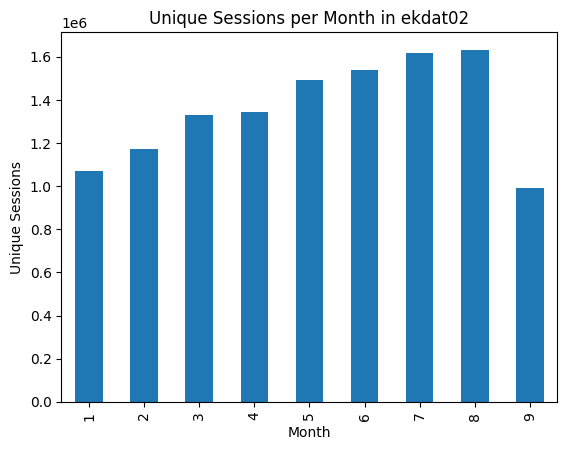

In [25]:

# Plot the number of unique sessions per month in ekdat02
# Load only the required columns to reduce memory usage
scanner = ekdat02_dataset.scanner(columns=['session_id_mask', 'session_received_utc'])
ekdat02_df = scanner.to_table().to_pandas()

# Ensure 'session_received_utc' is datetime, then extract the month
ekdat02_df['session_received_utc'] = pd.to_datetime(ekdat02_df['session_received_utc'], errors='coerce')
ekdat02_df['month'] = ekdat02_df['session_received_utc'].dt.month

# Group by month and count unique session IDs
sessions_per_month = ekdat02_df.groupby('month')['session_id_mask'].nunique()
sessions_per_month.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Unique Sessions')
plt.title('Unique Sessions per Month in ekdat02')
plt.show()

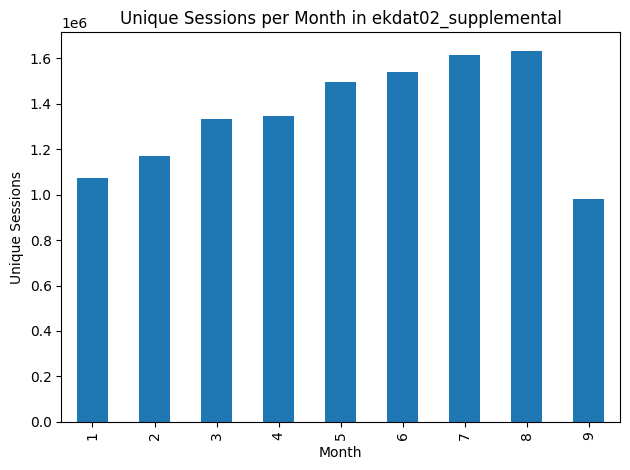

In [3]:
# Plot the number of unique sessions per month in ekdat02_supplemental

# Load only the required columns to reduce memory usage
scanner = ekdat02_supplemental_dataset.scanner(columns=['session_id_mask', 'date_time'])
ekdat02_supplemental_df = scanner.to_table().to_pandas()

# Ensure 'date_time' is datetime, then extract the month
ekdat02_supplemental_df['date_time'] = pd.to_datetime(ekdat02_supplemental_df['date_time'], errors='coerce')
ekdat02_supplemental_df['month'] = ekdat02_supplemental_df['date_time'].dt.month

# Group by month and count unique session IDs
sessions_per_month_supp = ekdat02_supplemental_df.groupby('month')['session_id_mask'].nunique()

# Plot
sessions_per_month_supp.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Unique Sessions')
plt.title('Unique Sessions per Month in ekdat02_supplemental')
plt.tight_layout()
plt.show()

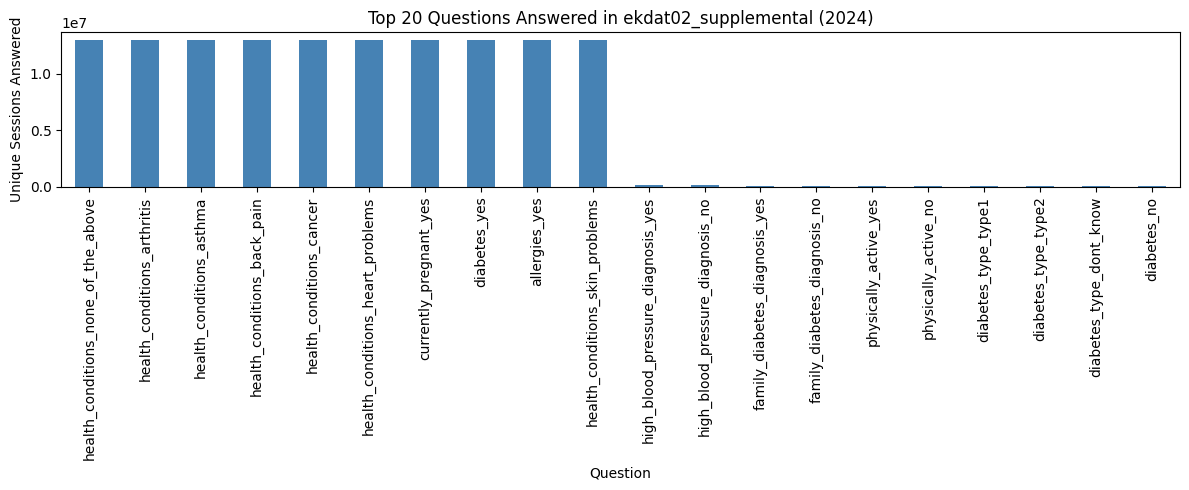

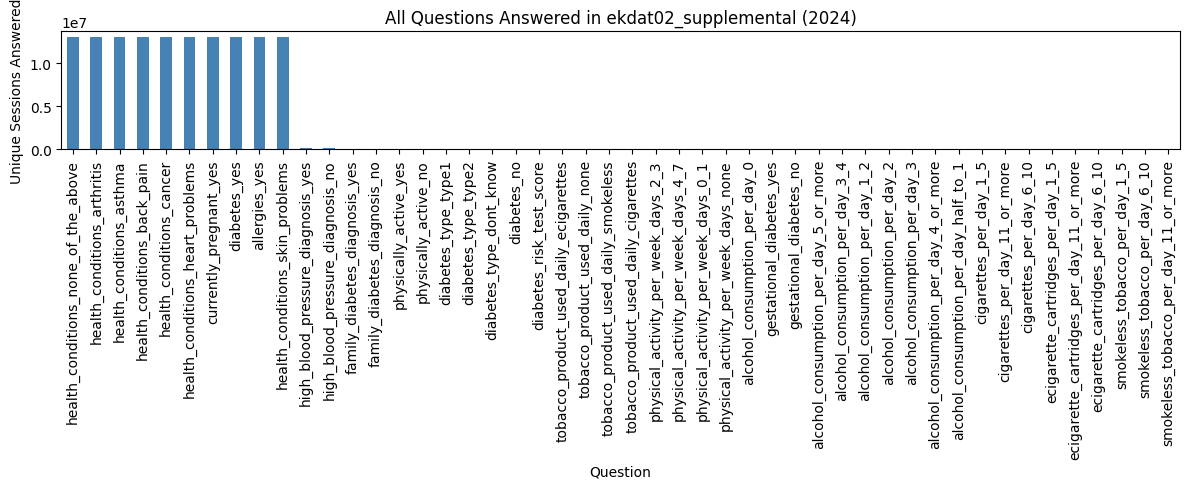

In [4]:
# Plot a bar chart of unique questions answered in ekdat02_supplemental in 2024
# === IMPORTS ===
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# === Step 1: Create a scanner for only the columns you need ===
scanner = ekdat02_supplemental_dataset.scanner(columns=['data_label_name', 'value', 'date_time'])

# === Step 2: Read batches instead of loading all into memory ===
batches = scanner.to_batches()

# === Step 3: Use a Counter to count answers per question ===
counts = Counter()

for batch in batches:
    dt = batch['date_time']
    if dt.type.tz is not None:
        dt = pc.cast(dt, pa.timestamp('ms'))  # Cast to naive timestamp
    # Extract year from timestamp directly
    years = pc.year(dt)
    mask_2024 = pc.equal(years, 2024)

    labels = batch['data_label_name'].filter(mask_2024)
    values = batch['value'].filter(mask_2024)

    for label, val in zip(labels, values):
        if val is not None:
            counts[label.as_py()] += 1

# === Step 4: Convert to pandas and plot ===
top_questions = pd.Series(counts).sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 5))
top_questions.plot(kind='bar', color='steelblue')
plt.xlabel('Question')
plt.ylabel('Unique Sessions Answered')
plt.title('Top 20 Questions Answered in ekdat02_supplemental (2024)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot all unique questions answered in ekdat02_supplemental in 2024 (not just top 20)
plt.figure(figsize=(max(12, len(counts) // 4), 5))
pd.Series(counts).sort_values(ascending=False).plot(kind='bar', color='steelblue')
plt.xlabel('Question')
plt.ylabel('Unique Sessions Answered')
plt.title('All Questions Answered in ekdat02_supplemental (2024)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [10]:
pd.Series(counts).to_csv(PATH_KIOSK_USER_PATTERNS_REPO / "data" / "kupdat02_ekdat02_supplemental counts for 2024.csv")

### Initial user patterns

There are many ways to capture user patterns. One such way is to conduct an unsupervised cluster analysis of users by what questions they chose to respond to.

1. Subset the patients for June to September 2024
2. Create a wide dataset such that each session is a row, and all questions associated with that session and its associated value is the column. Feel free to drop extra columns before that. Do let me know if you have any questions.
3. Fill in the missing values for all questions with 0
4. Run a cluster analysis so that you can see whether users responded to groups of questions and what those questions are: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html


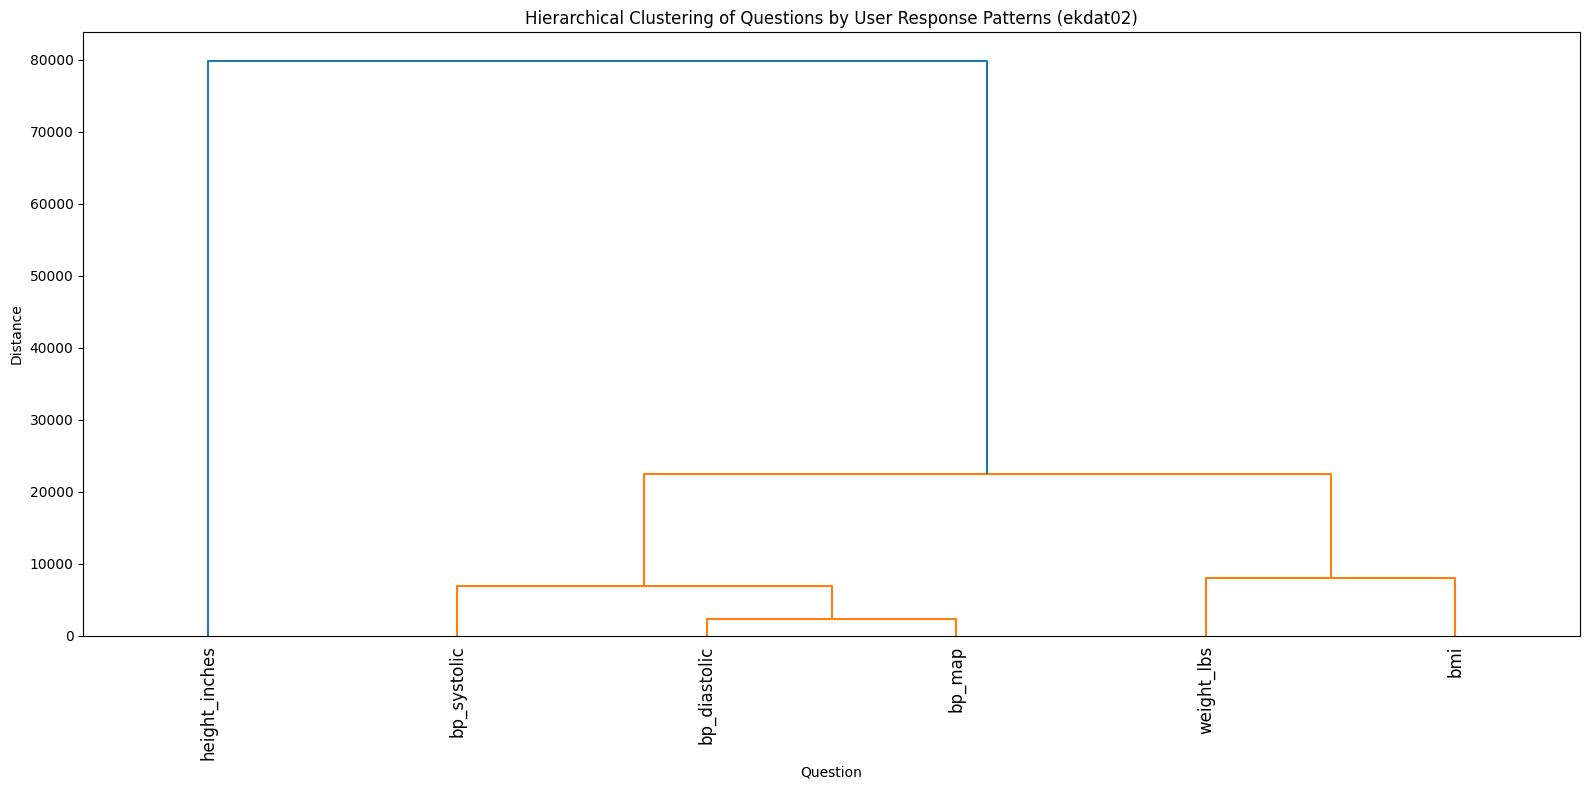

In [29]:
 # --- IMPORTS ---
import pyarrow.dataset as ds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from datetime import datetime

# --- CONFIG ---
dataset_path = ekdat02_path

# --- STEP 1: Load + Filter June–September 2024 Sessions ---
dataset = ds.dataset(dataset_path, format="parquet")
df = dataset.to_table().to_pandas()
df['session_received_utc'] = pd.to_datetime(df['session_received_utc'])

mask = (df['session_received_utc'] >= datetime(2024, 6, 1)) & (df['session_received_utc'] <= datetime(2024, 9, 30))
df = df[mask]

# --- STEP 2: Separate Metadata from Questions ---
metadata_cols = [
    'session_id_mask', 'account_id_mask', 'pseudo_member_id',
    'session_received_utc', 'session_started_local_time', 'timezone_offset',
    'location_name', 'street1', 'street2', 'city', 'state', 'zipcode',
    'birth_year', 'gender', 'ethnicity', 'year', 'month'
]
question_cols = [col for col in df.columns if col not in metadata_cols]

# --- STEP 3: Create Wide Format and Clean ---
wide_df = df[['pseudo_member_id', 'session_id_mask'] + question_cols].drop_duplicates(subset=['pseudo_member_id', 'session_id_mask']).copy()
wide_df[question_cols] = wide_df[question_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# --- STEP 4: Sample Up to 20,000 Sessions (Group First) ---
sample_df = wide_df.groupby(['pseudo_member_id', 'session_id_mask']).first().reset_index()
sample_df = sample_df.sample(n=min(20000, len(sample_df)), random_state=42)

# --- STEP 5: Transpose for Clustering ---
X = sample_df[question_cols]
X_t = X.T  # Transpose: questions as rows, users as columns

# --- STEP 6: Hierarchical Clustering ---
Z = linkage(X_t, method='ward')

# --- STEP 7: Plot Dendrogram ---
plt.figure(figsize=(16, 8))
dendrogram(Z, labels=X_t.index, leaf_rotation=90)
plt.title('Hierarchical Clustering of Questions by User Response Patterns (ekdat02)')
plt.xlabel('Question')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

In [30]:
sample_df.head(10)

,pseudo_member_id,session_id_mask,height_inches,weight_lbs,bmi,bp_systolic,bp_diastolic,bp_map
3339026,94016c73fb4e7642dc016e5669db4d3b410a608eb63cce...,45b9342b77fbb6acaaa5424ada46d2c3b9e08422b4cfd6...,0.0,0.00,0.0,121,74,90
852551,25bb0f1dbc1749bc6b33df7927b3634d6eb0ecb9f406f4...,82d792d1c89de3a1698c001b5f8c5193e15f4f7dee22b3...,0.0,0.00,0.0,139,88,105
4957296,db775366dd5ee31c180c409024ff45da303ac4f6dcb740...,5e1058accffbc07a17802faf287a107b5accffbde92e34...,0.0,0.00,0.0,126,69,88
310443,0db7aeb077d7072c48c58afa6098f51f2344ee873ffb2b...,321a811850789b3b1e6d00af1833d67884f998ee585521...,63.0,157.87,28.0,115,75,88
2101459,5d2754db340d31809a226b7e8de4661209835a55fae2a7...,cee4710ac39bc9920605f0869532723c68309dd7b37b58...,0.0,0.00,0.0,140,101,114
1222455,361f531acca05f03f52164f2fae1c5b3a71ca1fe7670dc...,19e8b01fbde2f3b4157c1f18c586dc5837f319042cb7fb...,0.0,0.00,0.0,132,77,95
1079226,2fce2e6c047faddc83842f5f4eea960f6f8f06b573451b...,baf3c91892c22756575c1a520a843158cf551577859856...,0.0,0.00,0.0,122,89,100
3802415,a87637e7a11a28902c76f60ba4f55b3b2fd795f008df19...,a4dfbfa3332b510c73b83e82c960fac8744bf004507953...,0.0,0.00,0.0,159,104,122
4962004,dba80141323fc194afb0c44c3b53465e24874191d227a6...,7107eaffa3edc38222a09f302cc3421f87d9f1c3173752...,0.0,0.00,0.0,139,59,86
5319759,eb8b736446c2509294fbcfb537932b93174e4e6135c1c3...,84e25557644c220e3e2aea5045636c6c3ef0d2db1fa97b...,69.0,0.00,0.0,106,87,93


In [31]:
X_t.head(10)

,3339026,852551,4957296,310443,2101459,1222455,1079226,3802415,4962004,5319759,...,5361403,3684808,208567,2689321,1954305,3364778,2988153,58610,26539,2429123
height_inches,0.0,0.0,0.0,63.00,0.0,0.0,0.0,0.0,0.0,69.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
weight_lbs,0.0,0.0,0.0,157.87,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bmi,0.0,0.0,0.0,28.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bp_systolic,121.0,139.0,126.0,115.00,140.0,132.0,122.0,159.0,139.0,106.0,...,147.0,139.0,166.0,141.0,137.0,119.0,141.0,150.0,148.0,139.0
bp_diastolic,74.0,88.0,69.0,75.00,101.0,77.0,89.0,104.0,59.0,87.0,...,92.0,71.0,83.0,95.0,93.0,61.0,90.0,103.0,83.0,60.0
bp_map,90.0,105.0,88.0,88.00,114.0,95.0,100.0,122.0,86.0,93.0,...,110.0,94.0,111.0,110.0,108.0,80.0,107.0,119.0,105.0,86.0


In [6]:
# Extract unique session IDs

# Filter to sessions in June–September 2024

# Read it as a scanner and in a loop to convert it into a wide dataframe
# OR Read it as a scanner and convert directly into a wide dataframe

import pyarrow.dataset as ds
import pandas as pd
import pyarrow as pa

# Step 1: Load dataset
# Use the already defined ekdat02_supplemental_dataset variable
scanner = ekdat02_supplemental_dataset.scanner(columns=["session_id_mask", "data_label_name", "value", "date_time"])

# Step 2: Read in batches and filter by date
batches = []
for batch in scanner.to_batches():
    df = batch.to_pandas()
    df["date_time"] = pd.to_datetime(df["date_time"], errors="coerce")
    mask = (df["date_time"] >= "2024-06-01") & (df["date_time"] <= "2024-09-30")
    filtered = df[mask]
    batches.append(filtered)

# Step 3: Combine and clean
df_step3a = pd.concat(batches, ignore_index=True)
df_step3b = df_step3a.dropna(subset=["data_label_name", "value"])

# Step 4: Pivot to wide format (session_id_mask × questions)
wide_df = df_step3b.pivot_table(
    index="session_id_mask",
    columns="data_label_name",
    values="value",
    aggfunc="first"
).apply(pd.to_numeric, errors="coerce").fillna(0)

In [7]:
df_step3a.head(10)

,session_id_mask,data_label_name,value,date_time
0,4bea5256c4813b105a006c51be41777d3fa6c01ba22260...,currently_pregnant_yes,0,2024-06-02 13:30:50+00:00
1,4bea5256c4813b105a006c51be41777d3fa6c01ba22260...,diabetes_yes,0,2024-06-02 13:30:50+00:00
2,4bea5256c4813b105a006c51be41777d3fa6c01ba22260...,health_conditions_arthritis,1,2024-06-02 13:30:50+00:00
3,4bea5256c4813b105a006c51be41777d3fa6c01ba22260...,health_conditions_asthma,0,2024-06-02 13:30:50+00:00
4,4bea5256c4813b105a006c51be41777d3fa6c01ba22260...,health_conditions_back_pain,0,2024-06-02 13:30:50+00:00
5,4bea5256c4813b105a006c51be41777d3fa6c01ba22260...,health_conditions_cancer,0,2024-06-02 13:30:50+00:00
6,4bea5256c4813b105a006c51be41777d3fa6c01ba22260...,health_conditions_heart_problems,0,2024-06-02 13:30:50+00:00
7,4bea5256c4813b105a006c51be41777d3fa6c01ba22260...,health_conditions_none_of_the_above,0,2024-06-02 13:30:50+00:00
8,4bea5256c4813b105a006c51be41777d3fa6c01ba22260...,allergies_yes,0,2024-06-02 13:30:50+00:00
9,4bea5256c4813b105a006c51be41777d3fa6c01ba22260...,health_conditions_skin_problems,0,2024-06-02 13:30:50+00:00


In [11]:
df_step3a.shape

(62583576, 4)

In [8]:
df_step3b.head(10)

,session_id_mask,data_label_name,value,date_time
0,4bea5256c4813b105a006c51be41777d3fa6c01ba22260...,currently_pregnant_yes,0,2024-06-02 13:30:50+00:00
1,4bea5256c4813b105a006c51be41777d3fa6c01ba22260...,diabetes_yes,0,2024-06-02 13:30:50+00:00
2,4bea5256c4813b105a006c51be41777d3fa6c01ba22260...,health_conditions_arthritis,1,2024-06-02 13:30:50+00:00
3,4bea5256c4813b105a006c51be41777d3fa6c01ba22260...,health_conditions_asthma,0,2024-06-02 13:30:50+00:00
4,4bea5256c4813b105a006c51be41777d3fa6c01ba22260...,health_conditions_back_pain,0,2024-06-02 13:30:50+00:00
5,4bea5256c4813b105a006c51be41777d3fa6c01ba22260...,health_conditions_cancer,0,2024-06-02 13:30:50+00:00
6,4bea5256c4813b105a006c51be41777d3fa6c01ba22260...,health_conditions_heart_problems,0,2024-06-02 13:30:50+00:00
7,4bea5256c4813b105a006c51be41777d3fa6c01ba22260...,health_conditions_none_of_the_above,0,2024-06-02 13:30:50+00:00
8,4bea5256c4813b105a006c51be41777d3fa6c01ba22260...,allergies_yes,0,2024-06-02 13:30:50+00:00
9,4bea5256c4813b105a006c51be41777d3fa6c01ba22260...,health_conditions_skin_problems,0,2024-06-02 13:30:50+00:00


In [12]:
df_step3b.shape

(62583576, 4)

In [9]:
wide_df.head(10)

data_label_name,alcohol_consumption_per_day_0,alcohol_consumption_per_day_1_2,alcohol_consumption_per_day_2,alcohol_consumption_per_day_3,alcohol_consumption_per_day_3_4,alcohol_consumption_per_day_4_or_more,alcohol_consumption_per_day_5_or_more,alcohol_consumption_per_day_half_to_1,allergies_yes,cigarettes_per_day_11_or_more,...,physical_activity_per_week_days_none,physically_active_no,physically_active_yes,smokeless_tobacco_per_day_11_or_more,smokeless_tobacco_per_day_1_5,smokeless_tobacco_per_day_6_10,tobacco_product_used_daily_cigarettes,tobacco_product_used_daily_ecigarettes,tobacco_product_used_daily_none,tobacco_product_used_daily_smokeless
session_id_mask,,,,,,,,,,,,,,,,,,,,,
000002d9da462dc4a45d5ee4c9b91ed7614e6fd9b4b48735abbdc2d45cebf817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00000461d955f03607ab96b7504ce794be57248c6707c9b682f7abc685e88453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00000607fafc5deeec8caba7bf74c4e68f1c5f917fc6f59f45eed6f1647252fa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000006ac0354ddc0fbb04f1e141a3b2406869c8b7841fb97c3aa0535b0477b86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00000b4ab7cf2820923fb50423171bda41f7d88a045d1af764e6880c25120aa3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00000d8fa5a70b380ba87219bd53eb8f3e02772bde059d4f2a321f99d6d1c0ef,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00000fbd3c8522ea8432a63f752fd15cf3d82db7882fae3d0e00737c4b31d842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000013e4c77906664d2742e0772160c3515378081e042ebda57f6fef3ca876f9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000014ae1a37567ed68f5cc357b56a887210868aac71301dffe13f29ea309c85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


🚀 Starting hierarchical clustering for ekdat02_supplemental...
Step 1: Filtering out low-variance questions...
✅ Retained 18 questions with sufficient variance
Step 2: Normalizing question responses...
✅ Retained 18 questions with sufficient variance
Step 2: Normalizing question responses...
Step 3: Transposing matrix for clustering...
✅ Transposed matrix shape: 18 questions × 5767752 sessions
Step 4: Performing hierarchical clustering using Ward's method...
Step 3: Transposing matrix for clustering...
✅ Transposed matrix shape: 18 questions × 5767752 sessions
Step 4: Performing hierarchical clustering using Ward's method...
✅ Clustering complete!
Step 5: Plotting dendrogram...
✅ Clustering complete!
Step 5: Plotting dendrogram...


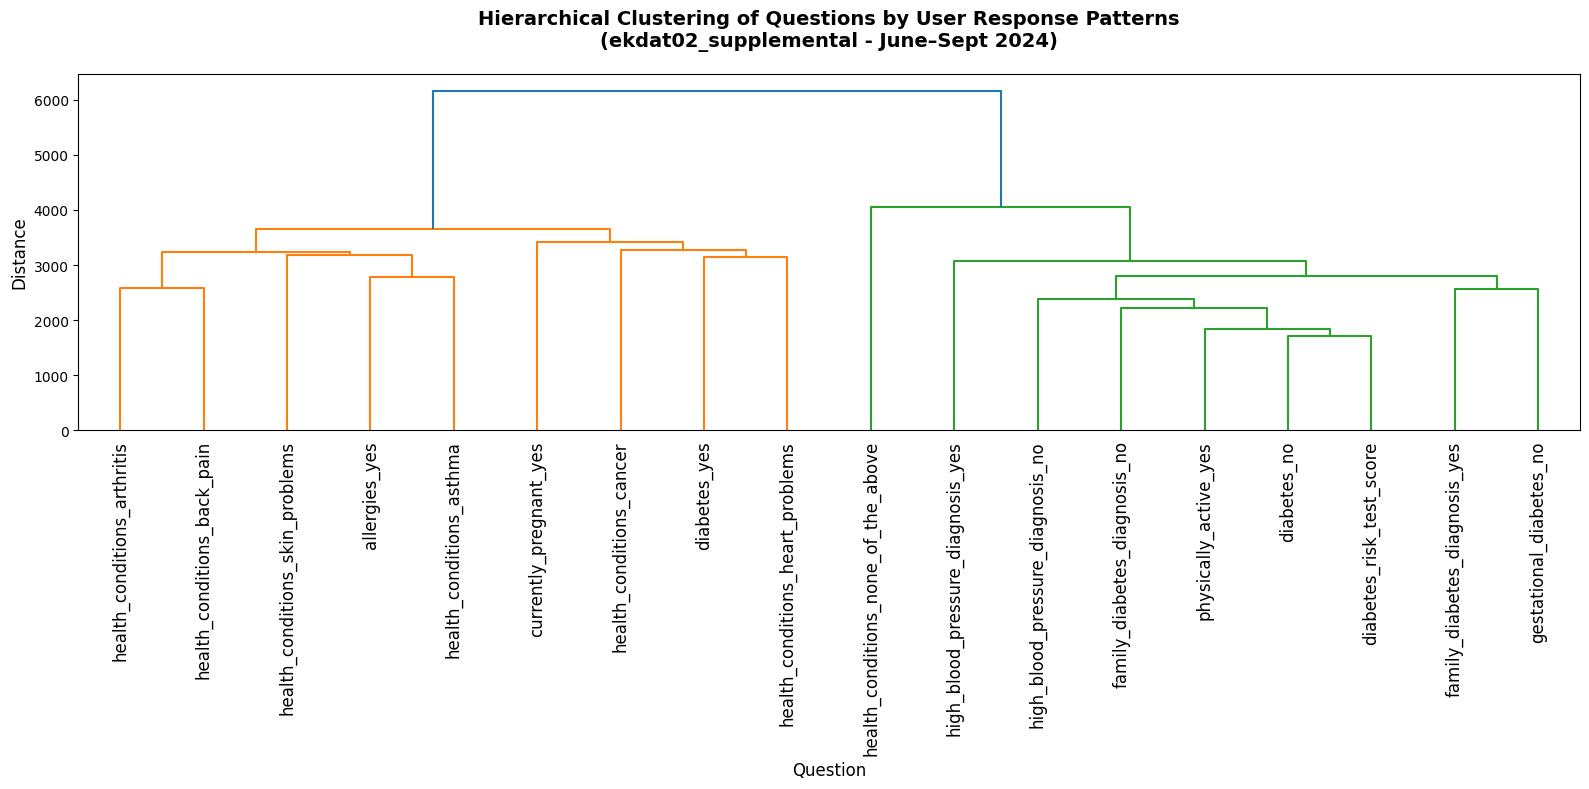

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

print("🚀 Starting hierarchical clustering for ekdat02_supplemental...")

# --- STEP 1: Filter out questions with little variation ---
print("Step 1: Filtering out low-variance questions...")
question_stds = wide_df.std()
variable_questions = question_stds[question_stds > 0.05].index  # You can adjust the threshold
wide_df = wide_df[variable_questions]
print(f"✅ Retained {len(variable_questions)} questions with sufficient variance")

# --- STEP 2: Normalize responses using z-scores ---
print("Step 2: Normalizing question responses...")
wide_df_z = (wide_df - wide_df.mean()) / wide_df.std()

# --- STEP 3: Transpose for clustering (questions as rows) ---
print("Step 3: Transposing matrix for clustering...")
X_t = wide_df_z.T  # Now rows = questions, columns = sessions
print(f"✅ Transposed matrix shape: {X_t.shape[0]} questions × {X_t.shape[1]} sessions")

# --- STEP 4: Perform hierarchical clustering ---
print("Step 4: Performing hierarchical clustering using Ward's method...")
Z = linkage(X_t, method='ward')
print("✅ Clustering complete!")

# --- STEP 5: Plot dendrogram ---
print("Step 5: Plotting dendrogram...")
plt.figure(figsize=(16, 8))
dendrogram(Z, labels=X_t.index, leaf_rotation=90)
plt.title('Hierarchical Clustering of Questions by User Response Patterns\n(ekdat02_supplemental - June–Sept 2024)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Question', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.show()

/var/folders/5c/j1qyt58n48724qt7xyp0z9140000gn/T/ipykernel_23530/1778419650.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["session_received_utc"] = pd.to_datetime(df["session_received_utc"], errors="coerce")
/var/folders/5c/j1qyt58n48724qt7xyp0z9140000gn/T/ipykernel_23530/1778419650.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["session_received_utc"] = pd.to_datetime(df["session_received_utc"], errors="coerce")
/var/folders/5c/j1qyt58n48724qt7xyp0z9140000gn/T/ipykernel_23530/1778419650.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["session_rec

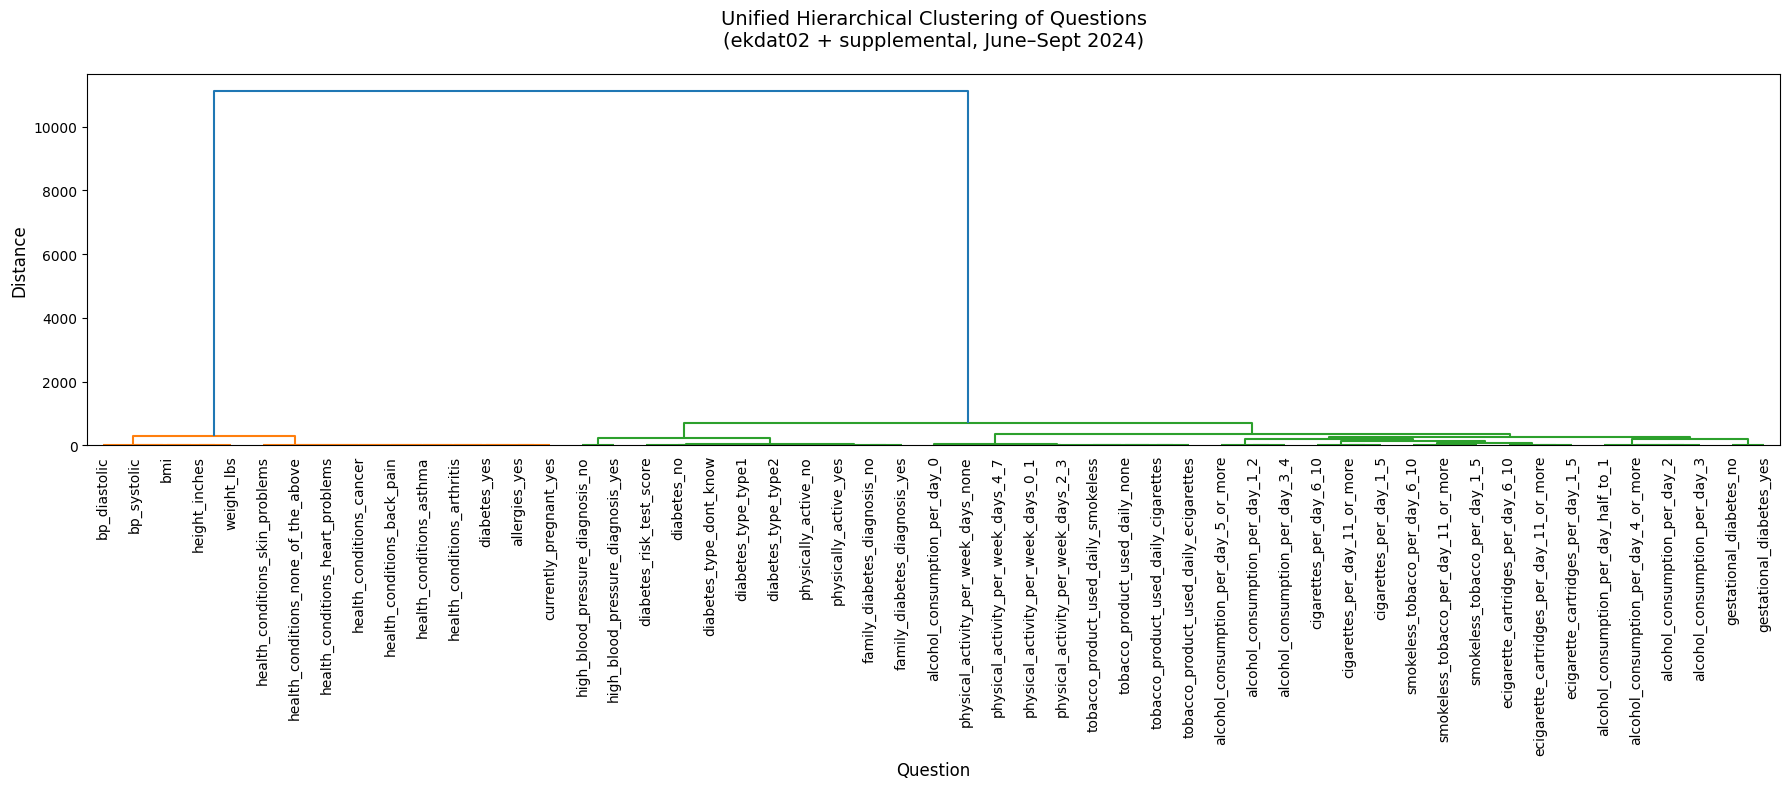

In [37]:
# Use the dataset created for hierarchical clustering of ekdat02 (wide) and ekdat02_supplemental (wide)

# Use full join to merge them such that all observations in either will be present


# ID - session ID - date - var 1 - var 2...
# === Unified Hierarchical Clustering: ekdat02 + ekdat02_supplemental (June–Sept 2024) ===

import pyarrow.dataset as ds
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# --- Step 1: Binary presence matrix for ekdat02 ---
ekdat02_columns = [
    "session_id_mask", "session_received_utc",
    "height_inches", "weight_lbs", "bmi", "bp_systolic", "bp_diastolic"
]

ekdat02_scanner = ekdat02_dataset.scanner(columns=ekdat02_columns)
ekdat02_batches = []
for batch in ekdat02_scanner.to_batches():
    df = batch.to_pandas()
    df["session_received_utc"] = pd.to_datetime(df["session_received_utc"], errors="coerce")
    mask = (df["session_received_utc"] >= "2024-06-01") & (df["session_received_utc"] <= "2024-09-30")
    df = df[mask]
    ekdat02_batches.append(df)

ekdat02_df = pd.concat(ekdat02_batches, ignore_index=True)
ekdat02_wide = ekdat02_df.set_index("session_id_mask")[ekdat02_columns[2:]]
ekdat02_wide = ekdat02_wide.notna().astype(int)

# --- Step 2: Binary presence matrix for ekdat02_supplemental ---
supp_scanner = ekdat02_supplemental_dataset.scanner(columns=["session_id_mask", "data_label_name", "value", "date_time"])
supp_batches = []
for batch in supp_scanner.to_batches():
    df = batch.to_pandas()
    df["date_time"] = pd.to_datetime(df["date_time"], errors="coerce")
    mask = (df["date_time"] >= "2024-06-01") & (df["date_time"] <= "2024-09-30")
    df = df[mask]
    supp_batches.append(df)

supp_df = pd.concat(supp_batches, ignore_index=True)
supp_df = supp_df.dropna(subset=["data_label_name", "value"])

ekdat02_supplemental_wide = supp_df.pivot_table(
    index="session_id_mask",
    columns="data_label_name",
    values="value",
    aggfunc="first"
).notna().astype(int)

# --- Step 3: Full outer join on session_id_mask ---
combined = ekdat02_wide.join(ekdat02_supplemental_wide, how="outer").fillna(0).astype(int)

# --- Step 4: Transpose for clustering and generate dendrogram ---
X_t = combined.T
Z = linkage(X_t, method="ward")

plt.figure(figsize=(18, 8))
dendrogram(Z, labels=X_t.index, leaf_rotation=90, leaf_font_size=10)
plt.title("Unified Hierarchical Clustering of Questions\n(ekdat02 + supplemental, June–Sept 2024)", fontsize=14, pad=20)
plt.xlabel("Question", fontsize=12)
plt.ylabel("Distance", fontsize=12)
plt.tight_layout()
plt.show()